# Visualise parish maps bounding boxes

This notebook visualises the results of my [attempts to create bounding boxes](process_parish_maps.ipynb) for the SLV's collection of parish maps by putting all the bounding boxes on a modern base map. Many of the bounding boxes overlap, so it's not an effective interface for finding and selecting individual maps. However, as you mouseover the bounding boxes the titles are shown, and if you click on a bounding box the metadata is displayed beneath the map, including a link to the SLV catalogue.

Seelect **Run > Run all cells** to display the map.

In [1]:
from shapely.geometry import box
from geopandas import GeoDataFrame
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoData, basemaps, LayersControl, WidgetControl
import ipywidgets as widgets
import requests

In [2]:
# Load the pre-processed data
df = pd.read_csv("parish_maps_final.csv")
# Only include maps with bounding boxes
df_boxes = df.copy().loc[df["bbox"].notnull()]

In [3]:
# Convert bbox strings to arrays
df_boxes["bbox"] = df_boxes["bbox"].apply(literal_eval)
df_boxes = df_boxes.loc[df_boxes["bbox"].str.len() != 0]

## Plot using Geopandas

For a quick look at the bounding boxes, we'll load them into Geopandas and plot the results.

In [4]:
# Convert bboxes to polygons for geopandas
geometry = []
for b in df_boxes["bbox"].to_list():
    try:
        geometry.append(box(b[0], b[1], b[2], b[3]))
    except IndexError:
        geometry.append(box())

In [5]:
df_boxes = df_boxes.drop(["bbox"], axis=1)
geodf = GeoDataFrame(df_boxes, geometry=geometry)

In [6]:
geodf.head()

,alma_id,title,coordinates,east,south,publisher,description,image_id,latitude,longitude,height,width,scale,ratio,geometry
0,9921177713607636,"Paaratte, County of Heytesbury",(E 142°59'/S 38°33').,E1425900,S0383300,"Melbourne :Dept. of Lands and Survey,1882.",1 map ;on sheet 58 x 42 cm.,IE7030338,-38.550000,142.983333,58.0,42.0,"Scale [ca. 1:31,680]",31680.0,"POLYGON ((143.05956 -38.63274, 143.05956 -38.4..."
1,9921177763607636,"Powlett, County of Gladstone",(E 143°51'/S 36°25').,E1435100,S0362500,"Melbourne :Dept. of Lands and Survey,1883.",1 map ;on sheet 33 x 69 cm.,IE7041050,-36.416667,143.850000,33.0,69.0,"Scale [ca. 1:31,680]",31680.0,"POLYGON ((143.97179 -36.46371, 143.97179 -36.3..."
2,9921177843607636,"Patho, County of Gunbower",(E 144°22'/S 35°59').,E1442200,S0353900,"Melbourne :H. J. Green, Govt. Printer,1926.",1 map ;on sheet 54 x 81 cm.,IE7022188,-35.650000,144.366667,54.0,81.0,Scale [ca. 1:31 680],31680.0,"POLYGON ((144.50821 -35.72701, 144.50821 -35.5..."
5,9921178453607636,"Stradbroke, County of Buln Buln",(E 146°56'/S 38°18').,E1465600,S0381800,"Melbourne :Dept. of Lands and Survey,1936.",1 map on 2 sheets ;on sheets 96 x 80 cm.,IE7041399,-38.300000,146.933333,96.0,80.0,Scale [1:15 840]. 20 chains to 1 in,15840.0,"POLYGON ((147.0057 -38.36847, 147.0057 -38.231..."
6,9921178773607636,"Paywit, County of Grant",(E 144°39'/S 38°12').,E1443900,S0381200,"Melbourne :Dept. of Lands and Survey,1905.",1 map ;on sheet 71 x 49 cm.,IE7024952,-38.200000,144.650000,71.0,49.0,"Scale [ca. 1: 31,680]",31680.0,"POLYGON ((144.73849 -38.30128, 144.73849 -38.0..."


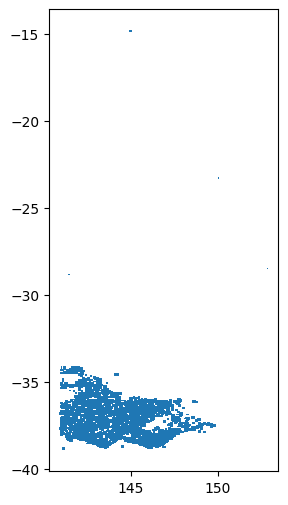

In [7]:
geodf.plot(figsize=(6, 6))
plt.show()

Hey, it looks like Victoria!

## Visualise using Leaflet

Now we'll feed the geodataframe to Leaflet, adding click and hover events to the rectangles to display metadata.

In [8]:
def get_iiif_id(manifest_url):
    """
    Extract a list of image @ids from an IIIF manifest
    """
    image_ids = []
    if manifest_url:
        try:
            response = requests.get(manifest_url, timeout=3)
        except requests.exceptions.Timeout:
            pass
        else:
            if response.ok:
                manifest = response.json()
                # There can be multiple images in a record
                # So we loop through the canvases to get each one.
                for canvas in manifest["sequences"][0]["canvases"]:
                    if canvas["images"][0]["resource"]["format"] == "image/jpeg":
                        image_ids.append(canvas["images"][0]["resource"]["service"]["@id"])
    return image_ids

def show_title(event=None, feature=None, id=None, properties=None, **kwargs):
    """
    Display the map title on hover
    """
    label.value = f"{properties.get('title').strip('/')} / {properties.get('publisher', '')}"

def show_details(event=None, feature=None, id=None, properties=None, **kwargs):
    """
    Display map metadata on click.
    """
    """
    # Manifests load too slowly to use them this way
    if properties["image_id"]:
        manifest_url = f"https://rosetta.slv.vic.gov.au/delivery/iiif/presentation/2.1/{properties['image_id']}/manifest.json"
        iiif_ids = get_iiif_id(manifest_url)
        try:
            image_url = f"{iiif_ids[0]}/full/!200,/0/default.jpg"
        except IndexError:
            image_url = None
    else:
        image_url = None
    """
    # print(properties)
    html = ""
    """
    if properties["iiif_ids"]:
        image_url = f"{properties['iiif_ids'].split('|')[0]}/full/!200,/0/default.jpg"
        html += f"<img src='{image_url}' style='float:right'>"
    """
    html += f"<p style='line-height: 1.2;'><b>{properties.get('title')}</b><br>"
    html += f"{properties['publisher']}<br>" if properties['publisher'] else ""
    html += f"{properties['description']}<br>" if properties['description'] else ""
    html += f"{properties['coordinates']}<br>" if properties['coordinates'] else ""
    html += f"{properties['scale']}<br>" if properties['scale'] else ""
    html += f"<a target='_blank' href='https://find.slv.vic.gov.au/discovery/fulldisplay?docid=alma{properties['alma_id']}&vid=61SLV_INST:SLV'>View in catalogue</a><br>"
    html += "</p>"
    details.value = html

# Make the map
default_layout = widgets.Layout(width="800px", height="500px")

# Create widgets to display info on hover and click
label = widgets.Label(layout=widgets.Layout(width="100%"))
details = widgets.HTML()

# Create the basemap and centre it on the map location
m = Map(
    center=(-37.815, 144.965),
    zoom=6,
    scroll_wheel_zoom=True,
    layout=default_layout,
)

# Add the label widget to the map to display map titles on hover
m.add_control(WidgetControl(widget=label, position='bottomleft'))

# Create the bbox layer from the geodf data
geo_data = GeoData(geo_dataframe=geodf, style={"weight": 1, "fillOpacity": .2}, hover_style={'color': 'red', 'fillColor': 'red' , 'fillOpacity': 0.2},)

# Show map title on hover
geo_data.on_hover(show_title)

# Display metadata when a bbox is clicked
geo_data.on_click(show_details)

# Add the bbox layer to the map
m.add(geo_data)

# Display the map and widgets
widgets.VBox([m, details])